In [2]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)


2.19.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
csv_path = "saleshourly.csv"   # <-- update with your CSV file
df = pd.read_csv(csv_path)
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [12]:
df["datum"] = pd.to_datetime(df["datum"])

In [13]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,2014-01-02 08:00:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,2014-01-02 09:00:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,2014-01-02 10:00:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,2014-01-02 11:00:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,2014-01-02 12:00:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [14]:
product_cols = ["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"]
data = df[["datum"] + product_cols].sort_values("datum").reset_index(drop=True)

In [15]:
# 3) Normalize (scale 0–1)
# ----------------------------
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data[product_cols])

In [16]:
# 4) Sequence preparation
# ----------------------------
def make_sequences(values, seq_len=168):  # 7 days (24*7 hours)
    X, y = [], []
    for i in range(seq_len, len(values)):
        X.append(values[i-seq_len:i])  # past window
        y.append(values[i])            # next step
    return np.array(X), np.array(y)

SEQ_LEN = 168   # 7 days lookback
X, y = make_sequences(scaled_values, seq_len=SEQ_LEN)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (50364, 168, 8) y shape: (50364, 8)


In [17]:
# 5) Train/Test split
# ----------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [18]:
# 6) Build LSTM Model
# ----------------------------
model = Sequential([
    LSTM(128, activation="tanh", input_shape=(SEQ_LEN, len(product_cols)), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation="tanh"),
    Dense(len(product_cols))   # predict all 8 products
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

c:\Users\visha\perplexity-pharma\ml-services\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 128)       │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,072 (469.03 KB)

 Trainable params: 120,072 (469.03 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 7) Train Model
# ----------------------------
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

In [1]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)

NameError: name 'model' is not defined

In [ ]:
# ----------------------------
# 8) Forecast Function
# ----------------------------
def forecast_future(model, last_values, horizon=48):
    """
    last_values: scaled array of shape (SEQ_LEN, num_features)
    horizon: number of future steps (hours)
    """
    seq = last_values.copy()
    preds = []
    for _ in range(horizon):
        pred = model.predict(seq.reshape(1, SEQ_LEN, len(product_cols)), verbose=0)[0]
        preds.append(pred)
        seq = np.vstack([seq[1:], pred])  # slide window
    preds = scaler.inverse_transform(np.array(preds))
    future_dates = pd.date_range(start=data["datum"].iloc[-1], periods=horizon+1, freq="H")[1:]
    return pd.DataFrame(preds, columns=product_cols, index=future_dates)

In [25]:
# 9) Run Forecast
# ----------------------------
forecast = forecast_future(model, scaled_values[-SEQ_LEN:], horizon=48)  # next 2 days
print(forecast.head())

                        M01AB     M01AE     N02BA     N02BE      N05B  \
2019-10-08 20:00:00  0.318794  0.271067  0.289522  2.508562  0.717983   
2019-10-08 21:00:00  0.258168  0.209457  0.227214  1.978543  0.607247   
2019-10-08 22:00:00  0.187140  0.145377  0.163532  1.389565  0.493065   
2019-10-08 23:00:00  0.118945  0.089930  0.107944  0.874643  0.387734   
2019-10-09 00:00:00  0.059750  0.045538  0.062316  0.467649  0.298097   

                         N05C       R03       R06  
2019-10-08 20:00:00  0.090488  0.523943  0.160657  
2019-10-08 21:00:00  0.074910  0.445735  0.126240  
2019-10-08 22:00:00  0.060140  0.344806  0.090506  
2019-10-08 23:00:00  0.047695  0.245441  0.057568  
2019-10-09 00:00:00  0.037714  0.157457  0.028627  


C:\Users\visha\AppData\Local\Temp\ipykernel_24772\1527067639.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=data["datum"].iloc[-1], periods=horizon+1, freq="H")[1:]


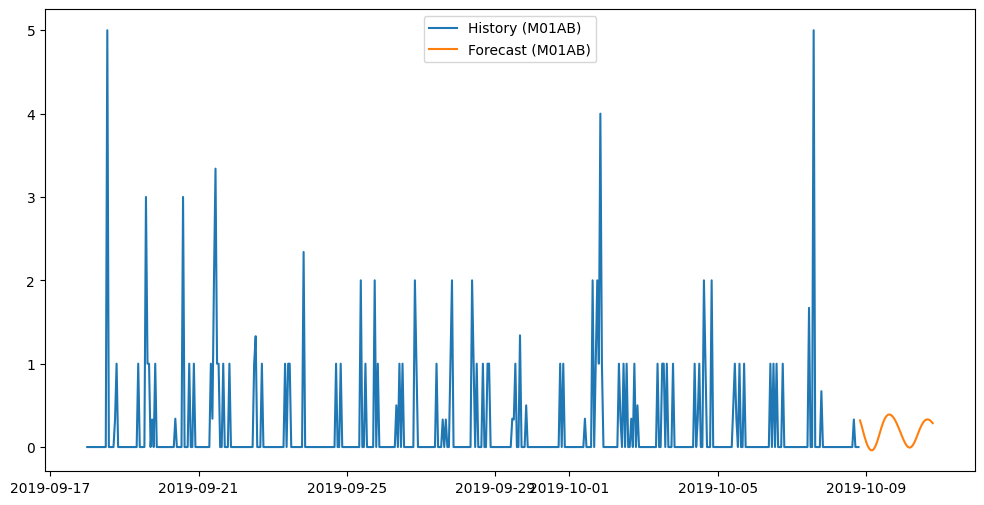

In [26]:
# 10) Plot Example Product
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(data["datum"].iloc[-500:], data["M01AB"].iloc[-500:], label="History (M01AB)")
plt.plot(forecast.index, forecast["M01AB"], label="Forecast (M01AB)")
plt.legend(); plt.show()

In [27]:
# Save the trained LSTM model
model.save("pharma_lstm_model.h5")

# Save the scaler for later (so predictions use same scaling)
import joblib
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved!")


✅ Model and scaler saved!
